In [1]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import numpy as np
from time import sleep
from datetime import datetime
import os
from dotenv import load_dotenv
from urllib.request import urlopen
import plotly 


In [2]:
load_dotenv()

token = os.getenv("TOKEN")
# Define the base URL for the API
base_url = "https://data.cityofnewyork.us/resource/8h9b-rp9u.json"

# Define headers including the app token
headers = {
    'X-App-Token': token
}

# Function to handle pagination, fetch all data, and implement a delay between requests
def fetch_all_data(base_url, headers, start_date, end_date):
    limit = 50000  # Adjust the limit as needed, depending on what the API allows
    offset = 0
    full_data = []

    # Format start and end dates for the API call
    formatted_start_date = datetime.strptime(start_date, "%Y-%m-%d").strftime('%Y-%m-%dT%H:%M:%S.%f')
    formatted_end_date = datetime.strptime(end_date, "%Y-%m-%d").strftime('%Y-%m-%dT%H:%M:%S.%f')

    while True:
        # Construct the query with pagination and date filtering
        query_url = f"{base_url}?$limit={limit}&$offset={offset}" \
                    f"&$where=ARREST_DATE between '{formatted_start_date}' and '{formatted_end_date}'"
        
        response = requests.get(query_url, headers=headers)
        if response.status_code != 200:
            print(f"Failed to fetch data: HTTP Status Code {response.status_code}")
            break
        
        data = response.json()
        if not data:
            break  # Break the loop if no more data is returned
        
        full_data.extend(data)
        offset += limit
        
        # Sleep for 1 seconds before making the next request
        sleep(1)
    
    return full_data

# Set your desired date range
start_date = '2014-01-01'
end_date = '2023-12-31'

# Fetch all data using the defined function
all_data = fetch_all_data(base_url, headers, start_date, end_date)

# Create a DataFrame from the fetched data
try :
    historical_df = pd.DataFrame(all_data)
except:
    print("Something went wrong....")

In [3]:
# Show 2023 arrest record DataFrame
historical_df.dropna(axis=1)
historical_df

arrest_key              arrest_date pd_cd  \
0         94273780  2014-01-01T00:00:00.000   397   
1         94272165  2014-01-01T00:00:00.000   205   
2         94273806  2014-01-01T00:00:00.000   750   
3         94272052  2014-01-01T00:00:00.000   109   
4         94259980  2014-01-01T00:00:00.000   101   
...            ...                      ...   ...   
2502237  279734477  2023-12-31T00:00:00.000   268   
2502238  279757488  2023-12-31T00:00:00.000   109   
2502239  279760036  2023-12-31T00:00:00.000   101   
2502240  279763279  2023-12-31T00:00:00.000   117   
2502241  279749403  2023-12-31T00:00:00.000   109   

                                 pd_desc ky_cd  \
0        ROBBERY,UNCLASSIFIED,OPEN AREAS   105   
1                   TRESPASS 2, CRIMINAL   352   
2                       RESISTING ARREST   359   
3               ASSAULT 2,1,UNCLASSIFIED   106   
4                              ASSAULT 3   344   
...                                  ...   ...   
2502237               CRIMINAL MIS 2 & 3   121   
2502238         ASSAULT 2,1,UNCLASSIFIED   106   
2502239                        ASSAULT 3   344   
2502240          RECKLESS ENDANGERMENT 1   126   
2502241         ASSAULT 2,1,UNCLASSIFIED   106   

                                      ofns_desc    law_code law_cat_cd  \
0                                       ROBBERY  PL 1601001          F   
1                             CRIMINAL TRESPASS  PL 1401500          M   
2        OFFENSES AGAINST PUBLIC ADMINISTRATION  PL 2053000          M   
3                                FELONY ASSAULT  PL 1200501          F   
4                  ASSAULT 3 & RELATED OFFENSES  PL 1200001          M   
...                                         ...         ...        ...   
2502237          CRIMINAL MISCHIEF & RELATED OF  PL 1450502          F   
2502238                          FELONY ASSAULT  PL 1200502          F   
2502239            ASSAULT 3 & RELATED OFFENSES  PL 1200001          M   
2502240                 MISCELLANEOUS PENAL LAW  PL 1202500          F   
2502241                          FELONY ASSAULT  PL 1200502          F   

        arrest_boro arrest_precinct jurisdiction_code age_group perp_sex  \
0                 B              44                 0       <18        M   
1                 M              26                 2     25-44        M   
2                 K              60                 2     25-44        M   
3                 B              41                 0     25-44        F   
4                 B              42                 2     25-44        M   
...             ...             ...               ...       ...      ...   
2502237           Q             107                 0     25-44        M   
2502238           K              68                 0     25-44        M   
2502239           B              48                 0     25-44        F   
2502240           Q             115                 0     25-44        M   
2502241           K              67                 0     45-64        M   

                              perp_race x_coord_cd y_coord_cd  \
0                                 BLACK  1006032.0   243764.0   
1                                 BLACK   996014.0   236126.0   
2                                 BLACK   986860.0   149123.0   
3                                 WHITE  1012777.0   237339.0   
4                        WHITE HISPANIC  1010896.0   244231.0   
...                                 ...        ...        ...   
2502237        ASIAN / PACIFIC ISLANDER    1050164     203112   
2502238  AMERICAN INDIAN/ALASKAN NATIVE     977714     169136   
2502239                  BLACK HISPANIC    1015053     247070   
2502240                  WHITE HISPANIC    1018032     214171   
2502241        ASIAN / PACIFIC ISLANDER     999236     175776   

                   latitude           longitude  \
0         40.83573258000007  -73.92128542599994   
1        40.814787465000045  -73.95750196499995   
2         40.57599199300005  -73.9

In [4]:
# Remove unwanted columns
historical_df.drop(columns=['pd_cd', 'arrest_key','law_cat_cd','law_code','pd_desc','x_coord_cd', 'y_coord_cd', 'ky_cd','arrest_precinct','jurisdiction_code' ], inplace=True)

In [5]:
# Rename Columns
new_column_names = {
    'arrest_date': 'Arrest date',
    'ofns_desc': 'Offense description',
    'arrest_boro': 'Arrest boro',
    'age_group': 'Age group',
    'perp_sex': 'Sex',
    'perp_race': 'Race',
    'latitude': 'Latitude',
    'longitude': 'Longitude'
}
historical_df.rename(columns=new_column_names,inplace=True)

In [6]:
historical_df

Arrest date                     Offense description  \
0        2014-01-01T00:00:00.000                                 ROBBERY   
1        2014-01-01T00:00:00.000                       CRIMINAL TRESPASS   
2        2014-01-01T00:00:00.000  OFFENSES AGAINST PUBLIC ADMINISTRATION   
3        2014-01-01T00:00:00.000                          FELONY ASSAULT   
4        2014-01-01T00:00:00.000            ASSAULT 3 & RELATED OFFENSES   
...                          ...                                     ...   
2502237  2023-12-31T00:00:00.000          CRIMINAL MISCHIEF & RELATED OF   
2502238  2023-12-31T00:00:00.000                          FELONY ASSAULT   
2502239  2023-12-31T00:00:00.000            ASSAULT 3 & RELATED OFFENSES   
2502240  2023-12-31T00:00:00.000                 MISCELLANEOUS PENAL LAW   
2502241  2023-12-31T00:00:00.000                          FELONY ASSAULT   

        Arrest boro Age group Sex                            Race  \
0                 B       <18   M                           BLACK   
1                 M     25-44   M                           BLACK   
2                 K     25-44   M                           BLACK   
3                 B     25-44   F                           WHITE   
4                 B     25-44   M                  WHITE HISPANIC   
...             ...       ...  ..                             ...   
2502237           Q     25-44   M        ASIAN / PACIFIC ISLANDER   
2502238           K     25-44   M  AMERICAN INDIAN/ALASKAN NATIVE   
2502239           B     25-44   F                  BLACK HISPANIC   
2502240           Q     25-44   M                  WHITE HISPANIC   
2502241           K     45-64   M        ASIAN / PACIFIC ISLANDER   

                   Latitude           Longitude  \
0         40.83573258000007  -73.92128542599994   
1        40.814787465000045  -73.95750196499995   
2         40.57599199300005  -73.99060607299998   
3         40.81807858500007  -73.89693760899996   
4        40.837001024000074  -73.90370600899996   
...                     ...                 ...   
2502237           40.723928          -73.762197   
2502238           40.630914          -74.023544   
2502239           40.844774          -73.888668   
2502240           40.754464          -73.878064   
2502241            40.64913          -73.945994   

                                                   lon_lat  
0        {'type': 'Point', 'coordinates': [-73.92128542...  
1        {'type': 'Point', 'coordinates': [-73.95750196...  
2        {'type': 'Point', 'coordinates': [-73.99060607...  
3        {'type': 'Point', 'coordinates': [-73.89693760...  
4        {'type': 'Point', 'coordinates': [-73.90370600...  
...                                                    ...  
2502237  {'type': 'Point', 'coordinates': [-73.762197, ...  
2502238  {'type': 'Point', 'coordinates': [-74.023544, ...  
2502239  {'type': 'Point', 'coordinates': [-73.888668, ...  
2502240  {'type': 'Point', 'coordinates': [-73.878064, ...  
2502241  {'type': 'Point', 'coordinates': [-73.945994, ...  

[2502242 rows x 9 columns]

In [7]:
# Save data to file
historical_df.to_csv('./output/2023_data.csv', index=False)

In [114]:
historical_df_from_file = pd.read_csv("./output/2023_data.csv")
historical_df_from_file

Arrest date                     Offense description  \
0        2014-01-01T00:00:00.000                                 ROBBERY   
1        2014-01-01T00:00:00.000                       CRIMINAL TRESPASS   
2        2014-01-01T00:00:00.000  OFFENSES AGAINST PUBLIC ADMINISTRATION   
3        2014-01-01T00:00:00.000                          FELONY ASSAULT   
4        2014-01-01T00:00:00.000            ASSAULT 3 & RELATED OFFENSES   
...                          ...                                     ...   
2502237  2023-12-31T00:00:00.000          CRIMINAL MISCHIEF & RELATED OF   
2502238  2023-12-31T00:00:00.000                          FELONY ASSAULT   
2502239  2023-12-31T00:00:00.000            ASSAULT 3 & RELATED OFFENSES   
2502240  2023-12-31T00:00:00.000                 MISCELLANEOUS PENAL LAW   
2502241  2023-12-31T00:00:00.000                          FELONY ASSAULT   

        Arrest boro Age group Sex                            Race   Latitude  \
0                 B       <18   M                           BLACK  40.835733   
1                 M     25-44   M                           BLACK  40.814787   
2                 K     25-44   M                           BLACK  40.575992   
3                 B     25-44   F                           WHITE  40.818079   
4                 B     25-44   M                  WHITE HISPANIC  40.837001   
...             ...       ...  ..                             ...        ...   
2502237           Q     25-44   M        ASIAN / PACIFIC ISLANDER  40.723928   
2502238           K     25-44   M  AMERICAN INDIAN/ALASKAN NATIVE  40.630914   
2502239           B     25-44   F                  BLACK HISPANIC  40.844774   
2502240           Q     25-44   M                  WHITE HISPANIC  40.754464   
2502241           K     45-64   M        ASIAN / PACIFIC ISLANDER  40.649130   

         Longitude                                            lon_lat  
0       -73.921285  {'type': 'Point', 'coordinates': [-73.92128542...  
1       -73.957502  {'type': 'Point', 'coordinates': [-73.95750196...  
2       -73.990606  {'type': 'Point', 'coordinates': [-73.99060607...  
3       -73.896938  {'type': 'Point', 'coordinates': [-73.89693760...  
4       -73.903706  {'type': 'Point', 'coordinates': [-73.90370600...  
...            ...                                                ...  
2502237 -73.762197  {'type': 'Point', 'coordinates': [-73.762197, ...  
2502238 -74.023544  {'type': 'Point', 'coordinates': [-74.023544, ...  
2502239 -73.888668  {'type': 'Point', 'coordinates': [-73.888668, ...  
2502240 -73.878064  {'type': 'Point', 'coordinates': [-73.878064, ...  
2502241 -73.945994  {'type': 'Point', 'coordinates': [-73.945994, ...  

[2502242 rows x 9 columns]

In [9]:
def showPieChart(data: pd.Series,date :str):
    plt.figure(figsize=(10, 6))
    data.plot(kind='pie', autopct='%1.1f%%', startangle=140)
    plt.title(f'Distribution of Offenses {date}')
    plt.ylabel('')  # Remove the y-label which shows the column name
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.show()

def showChart(data: pd.Series,date :str):
    plt.figure(figsize=(10, 6))
    data.plot(kind='bar', color='red')
    plt.title(f'Top 5 {date} Offenses')
    plt.xlabel('Offense Description')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [10]:
offense_counts_2023 = historical_df_from_file['Offense description'].value_counts()
# Sort offenses by counts in descending order
sorted_offenses_2023 = offense_counts_2023.sort_values(ascending=False)
top_15_offenses_2023 = sorted_offenses_2023.head(15)
# Select the top 5 offenses 2023
top_5_offenses_2023 = sorted_offenses_2023.head(5)

In [97]:
# Set the base URL
base_url = "https://data.cityofnewyork.us/resource/uip8-fykc.json?"
# Set the query URL
query_url = base_url + "$limit=50000"
response = requests.get(query_url).json()
# Create a DataFrame
try:
    original_df = pd.DataFrame(response)
except : 
    print("Something went wrong...")
# Display original df
original_df

arrest_key              arrest_date pd_cd  \
0      280255493  2024-01-10T00:00:00.000   397   
1      279805419  2024-01-02T00:00:00.000   157   
2      279895750  2024-01-03T00:00:00.000   101   
3      280809090  2024-01-19T00:00:00.000   511   
4      280357135  2024-01-11T00:00:00.000   109   
...          ...                      ...   ...   
49995  283662436  2024-03-12T00:00:00.000   268   
49996  284068720  2024-03-20T00:00:00.000   105   
49997  283384015  2024-03-07T00:00:00.000   114   
49998  283729925  2024-03-14T00:00:00.000   101   
49999  283700123  2024-03-13T00:00:00.000   503   

                              pd_desc ky_cd                       ofns_desc  \
0      ROBBERY,OPEN AREA UNCLASSIFIED   105                         ROBBERY   
1                              RAPE 1   104                            RAPE   
2                           ASSAULT 3   344    ASSAULT 3 & RELATED OFFENSES   
3      CONTROLLED SUBSTANCE, POSSESSI   235                 DANGEROUS DRUGS   
4            ASSAULT 2,1,UNCLASSIFIED   106                  FELONY ASSAULT   
...                               ...   ...                             ...   
49995              CRIMINAL MIS 2 & 3   121  CRIMINAL MISCHIEF & RELATED OF   
49996               STRANGULATION 1ST   106                  FELONY ASSAULT   
49997             OBSTR BREATH/CIRCUL   344    ASSAULT 3 & RELATED OFFENSES   
49998                       ASSAULT 3   344    ASSAULT 3 & RELATED OFFENSES   
49999  CONTROLLED SUBSTANCE,INTENT TO   117                 DANGEROUS DRUGS   

         law_code law_cat_cd arrest_boro arrest_precinct jurisdiction_code  \
0      PL 1601001          F           M              26                 0   
1      PL 1303501          F           K              77                 0   
2      PL 1200001          M           Q             106                 0   
3      PL 2200300          M           B              49                 0   
4      PL 1200502          F           K              81                 2   
...           ...        ...         ...             ...               ...   
49995  PL 1450502          F           K              84                 0   
49996  PL 1211300          F           M              25                 0   
49997  PL 121110A          M           M              28                 0   
49998  PL 1200001          M           B              48                 0   
49999  PL 2201601          F           Q             102                 0   

      age_group perp_sex       perp_race x_coord_cd y_coord_cd  \
0           <18        M           BLACK     996342     236149   
1         25-44        M  WHITE HISPANIC    1003509     185018   
2           65+        F           WHITE    1026836     180689   
3         45-64        M           BLACK    1027430     251104   
4         25-44        F           BLACK    1002457     192292   
...         ...      ...             ...        ...        ...   
49995       65+        F           BLACK     988174     190975   
49996     25-44        M  BLACK HISPANIC    1002076     231440   
49997     25-44        M           BLACK     997373     231879   
49998     25-44        F  WHITE HISPANIC    1015629     246174   
49999     25-44        M  WHITE HISPANIC    1030409     189906   

                 latitude           longitude  \
0               40.814845          -73.956312   
1        40.6744956865259   -73.9305713255961   
2               40.662526          -73.846499   
3               40.855793          -73.843908   
4               40.694456          -73.934343   
...                   ...                 ...   
49995           40.690859          -73.985848   
49996           40.801908          -73.935612   
49997           40.803121          -73.952599   
49998           40.842311          -73.886588   
49999  40.687804468530956  -73.83356012817558   

                                         geocoded_column  \
0      {'type': 'Point', 'coordinates': [-73.956312, ...   
1    

In [12]:
original_df.dtypes

arrest_key                     object
arrest_date                    object
pd_cd                          object
pd_desc                        object
ky_cd                          object
ofns_desc                      object
law_code                       object
law_cat_cd                     object
arrest_boro                    object
arrest_precinct                object
jurisdiction_code              object
age_group                      object
perp_sex                       object
perp_race                      object
x_coord_cd                     object
y_coord_cd                     object
latitude                       object
longitude                      object
geocoded_column                object
:@computed_region_f5dn_yrer    object
:@computed_region_yeji_bk3q    object
:@computed_region_92fq_4b7q    object
:@computed_region_sbqj_enih    object
:@computed_region_efsh_h5xi    object
dtype: object

In [98]:
original_df.columns

Index(['arrest_key', 'arrest_date', 'pd_cd', 'pd_desc', 'ky_cd', 'ofns_desc',
       'law_code', 'law_cat_cd', 'arrest_boro', 'arrest_precinct',
       'jurisdiction_code', 'age_group', 'perp_sex', 'perp_race', 'x_coord_cd',
       'y_coord_cd', 'latitude', 'longitude', 'geocoded_column',
       ':@computed_region_f5dn_yrer', ':@computed_region_yeji_bk3q',
       ':@computed_region_92fq_4b7q', ':@computed_region_sbqj_enih',
       ':@computed_region_efsh_h5xi'],
      dtype='object')

In [99]:
original_df.drop(columns=['pd_cd','pd_desc','law_cat_cd','arrest_key','arrest_precinct','x_coord_cd', 'y_coord_cd', 'ky_cd',\
                           'jurisdiction_code', ':@computed_region_f5dn_yrer', ':@computed_region_yeji_bk3q',\
                            ':@computed_region_92fq_4b7q', ':@computed_region_sbqj_enih', ':@computed_region_efsh_h5xi',\
                                'law_code'], inplace=True)

In [101]:
original_df.dropna(inplace=True)
original_df =original_df[original_df['arrest_date'] != 'null']
original_df =original_df[original_df['ofns_desc'] != 'null']
original_df

arrest_date                       ofns_desc arrest_boro  \
0      2024-01-10T00:00:00.000                         ROBBERY           M   
1      2024-01-02T00:00:00.000                            RAPE           K   
2      2024-01-03T00:00:00.000    ASSAULT 3 & RELATED OFFENSES           Q   
3      2024-01-19T00:00:00.000                 DANGEROUS DRUGS           B   
4      2024-01-11T00:00:00.000                  FELONY ASSAULT           K   
...                        ...                             ...         ...   
49995  2024-03-12T00:00:00.000  CRIMINAL MISCHIEF & RELATED OF           K   
49996  2024-03-20T00:00:00.000                  FELONY ASSAULT           M   
49997  2024-03-07T00:00:00.000    ASSAULT 3 & RELATED OFFENSES           M   
49998  2024-03-14T00:00:00.000    ASSAULT 3 & RELATED OFFENSES           B   
49999  2024-03-13T00:00:00.000                 DANGEROUS DRUGS           Q   

      age_group perp_sex       perp_race            latitude  \
0           <18        M           BLACK           40.814845   
1         25-44        M  WHITE HISPANIC    40.6744956865259   
2           65+        F           WHITE           40.662526   
3         45-64        M           BLACK           40.855793   
4         25-44        F           BLACK           40.694456   
...         ...      ...             ...                 ...   
49995       65+        F           BLACK           40.690859   
49996     25-44        M  BLACK HISPANIC           40.801908   
49997     25-44        M           BLACK           40.803121   
49998     25-44        F  WHITE HISPANIC           40.842311   
49999     25-44        M  WHITE HISPANIC  40.687804468530956   

                longitude                                    geocoded_column  
0              -73.956312  {'type': 'Point', 'coordinates': [-73.956312, ...  
1       -73.9305713255961  {'type': 'Point', 'coordinates': [-73.93057132...  
2              -73.846499  {'type': 'Point', 'coordinates': [-73.846499, ...  
3              -73.843908  {'type': 'Point', 'coordinates': [-73.843908, ...  
4              -73.934343  {'type': 'Point', 'coordinates': [-73.934343, ...  
...                   ...                                                ...  
49995          -73.985848  {'type': 'Point', 'coordinates': [-73.985848, ...  
49996          -73.935612  {'type': 'Point', 'coordinates': [-73.935612, ...  
49997          -73.952599  {'type': 'Point', 'coordinates': [-73.952599, ...  
49998          -73.886588  {'type': 'Point', 'coordinates': [-73.886588, ...  
49999  -73.83356012817558  {'type': 'Point', 'coordinates': [-73.83356012...  

[50000 rows x 9 columns]

In [102]:
original_df.columns

Index(['arrest_date', 'ofns_desc', 'arrest_boro', 'age_group', 'perp_sex',
       'perp_race', 'latitude', 'longitude', 'geocoded_column'],
      dtype='object')

In [103]:
original_df.rename(columns=new_column_names,inplace=True)
original_df.columns

Index(['Arrest date', 'Offense description', 'Arrest boro', 'Age group', 'Sex',
       'Race', 'Latitude', 'Longitude', 'geocoded_column'],
      dtype='object')

In [104]:
original_df

Arrest date             Offense description Arrest boro  \
0      2024-01-10T00:00:00.000                         ROBBERY           M   
1      2024-01-02T00:00:00.000                            RAPE           K   
2      2024-01-03T00:00:00.000    ASSAULT 3 & RELATED OFFENSES           Q   
3      2024-01-19T00:00:00.000                 DANGEROUS DRUGS           B   
4      2024-01-11T00:00:00.000                  FELONY ASSAULT           K   
...                        ...                             ...         ...   
49995  2024-03-12T00:00:00.000  CRIMINAL MISCHIEF & RELATED OF           K   
49996  2024-03-20T00:00:00.000                  FELONY ASSAULT           M   
49997  2024-03-07T00:00:00.000    ASSAULT 3 & RELATED OFFENSES           M   
49998  2024-03-14T00:00:00.000    ASSAULT 3 & RELATED OFFENSES           B   
49999  2024-03-13T00:00:00.000                 DANGEROUS DRUGS           Q   

      Age group Sex            Race            Latitude           Longitude  \
0           <18   M           BLACK           40.814845          -73.956312   
1         25-44   M  WHITE HISPANIC    40.6744956865259   -73.9305713255961   
2           65+   F           WHITE           40.662526          -73.846499   
3         45-64   M           BLACK           40.855793          -73.843908   
4         25-44   F           BLACK           40.694456          -73.934343   
...         ...  ..             ...                 ...                 ...   
49995       65+   F           BLACK           40.690859          -73.985848   
49996     25-44   M  BLACK HISPANIC           40.801908          -73.935612   
49997     25-44   M           BLACK           40.803121          -73.952599   
49998     25-44   F  WHITE HISPANIC           40.842311          -73.886588   
49999     25-44   M  WHITE HISPANIC  40.687804468530956  -73.83356012817558   

                                         geocoded_column  
0      {'type': 'Point', 'coordinates': [-73.956312, ...  
1      {'type': 'Point', 'coordinates': [-73.93057132...  
2      {'type': 'Point', 'coordinates': [-73.846499, ...  
3      {'type': 'Point', 'coordinates': [-73.843908, ...  
4      {'type': 'Point', 'coordinates': [-73.934343, ...  
...                                                  ...  
49995  {'type': 'Point', 'coordinates': [-73.985848, ...  
49996  {'type': 'Point', 'coordinates': [-73.935612, ...  
49997  {'type': 'Point', 'coordinates': [-73.952599, ...  
49998  {'type': 'Point', 'coordinates': [-73.886588, ...  
49999  {'type': 'Point', 'coordinates': [-73.83356012...  

[50000 rows x 9 columns]

In [19]:
pd.set_option('display.max_rows', 200)

In [85]:
original_df['Offense description'].value_counts()

Offense description
ASSAULT 3 & RELATED OFFENSES            6940
PETIT LARCENY                           5048
FELONY ASSAULT                          4079
DANGEROUS DRUGS                         3787
VEHICLE AND TRAFFIC LAWS                3183
MISCELLANEOUS PENAL LAW                 3148
GRAND LARCENY                           2431
ROBBERY                                 2358
CRIMINAL MISCHIEF & RELATED OF          2243
DANGEROUS WEAPONS                       1951
OTHER OFFENSES RELATED TO THEF          1765
OFFENSES AGAINST PUBLIC ADMINI          1538
BURGLARY                                1249
OFFENSES INVOLVING FRAUD                1103
SEX CRIMES                              1070
FORGERY                                 1009
OFF. AGNST PUB ORD SENSBLTY &            880
POSSESSION OF STOLEN PROPERTY            861
CRIMINAL TRESPASS                        607
OTHER TRAFFIC INFRACTION                 596
INTOXICATED & IMPAIRED DRIVING           505
GRAND LARCENY OF MOTOR VEHICLE     

In [87]:
offense_counts_2024 = original_df['Offense description'].value_counts()
# Sort offenses by counts in descending order
sorted_offenses_2024 = offense_counts_2024.sort_values(ascending=False)
top_15_offenses_2024 = sorted_offenses_2024.head(15)
# Select the top 5 offenses 2024
top_5_offenses_2024 = sorted_offenses_2024.head(5)

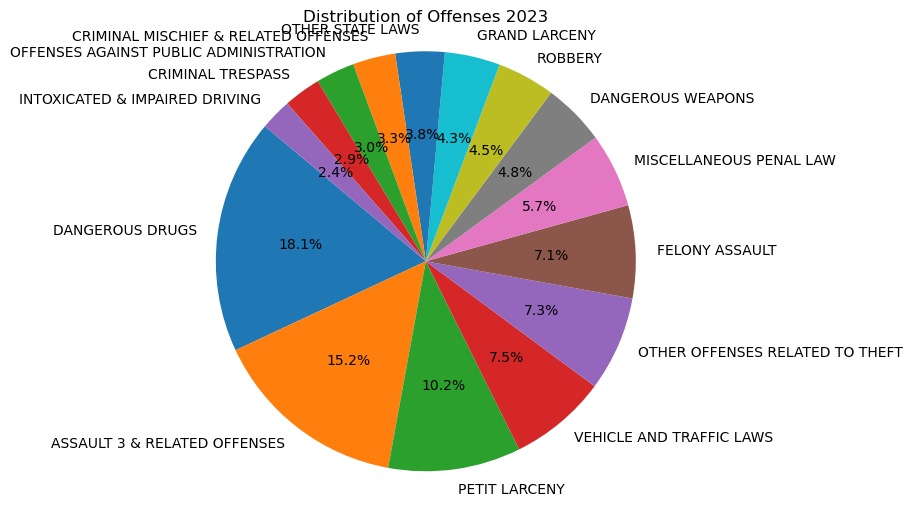

In [88]:
# Plot the top 15 offenses2023
showPieChart(top_15_offenses_2023,"2023")

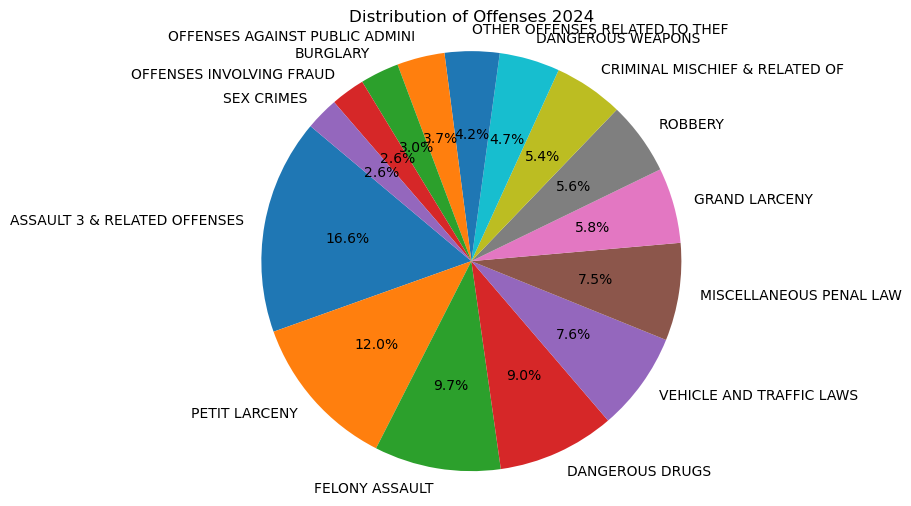

In [89]:
# Plot the top 15 offenses 2024
showPieChart(top_15_offenses_2024,"2024")

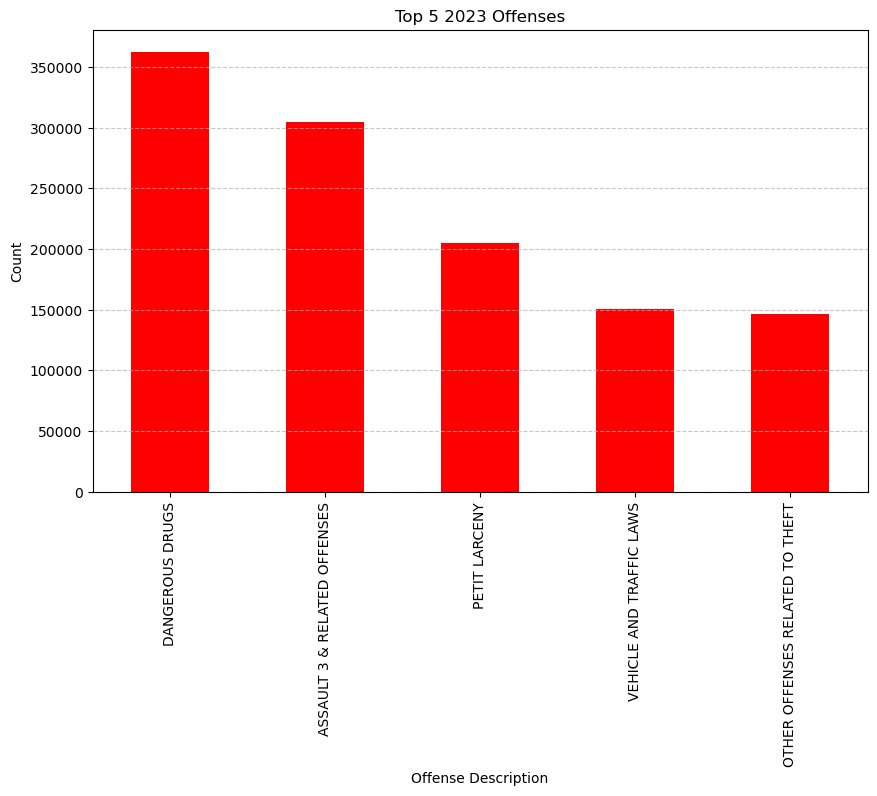

In [90]:
# Plot the top 5 offenses 2023
showChart(top_5_offenses_2023,"2023")

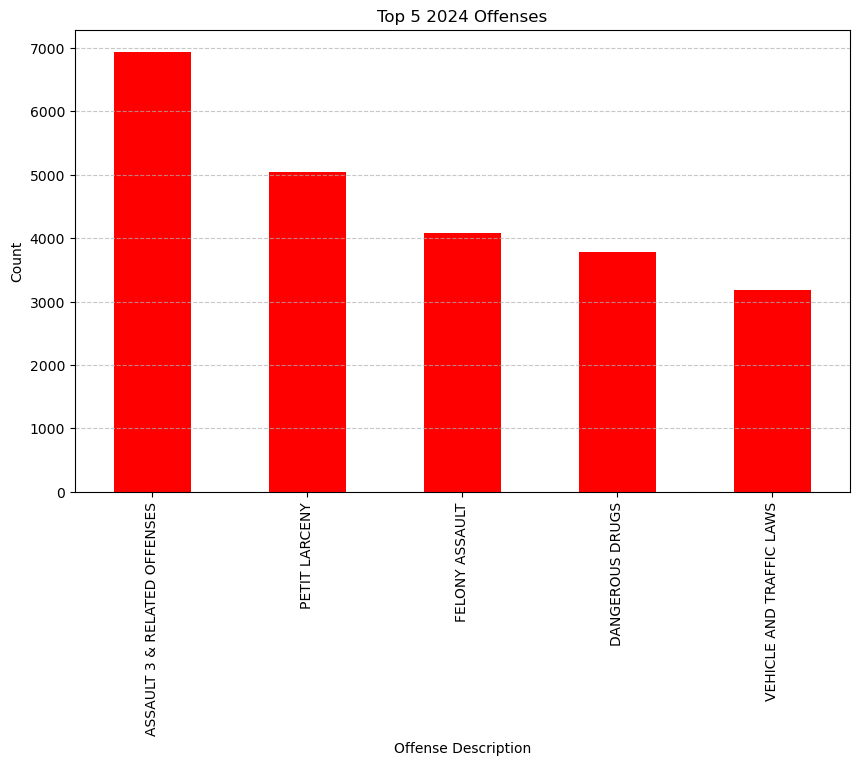

In [91]:
# Plot the top 5 offenses 2024
showChart(top_5_offenses_2024,"2024")

In [105]:
import plotly.express as px
# converint coordinates to numeric
original_df['Latitude'] = pd.to_numeric(original_df['Latitude'], errors='coerce')
original_df['Longitude'] = pd.to_numeric(original_df['Longitude'], errors='coerce')
fig = px.scatter_mapbox(original_df, lat='Latitude', lon='Longitude', color='Arrest date',
                        mapbox_style='carto-positron', zoom=10, opacity=0.5,
                        center={'lat': original_df['Latitude'].mean(), 'lon': original_df['Longitude'].mean()},
                        title='Crime dates per borough 2024')

# Ensure markers are shown
fig.update_traces(mode='markers', marker=dict(size=10))
# Show the figure
fig.show()

In [167]:
fig = px.scatter_mapbox(original_df, lat='Latitude', lon='Longitude', color='Offense description',
                        mapbox_style='carto-positron', zoom=10, opacity=0.5,
                        center={'lat': original_df['Latitude'].mean(), 'lon': original_df['Longitude'].mean()},
                        title='Offenses per borough 2024')

# Ensure markers are shown
fig.update_traces(mode='markers', marker=dict(size=10))
# Show the figure
fig.show()

In [26]:
pd.set_option('display.max_columns', None)

In [27]:
grouped_by_boro_2024=original_df.groupby('Arrest boro')[['Arrest date']].count()
grouped_by_boro_2024

Arrest date
Arrest boro             
B                  11227
K                  13612
M                  12024
Q                  10878
S                   2259

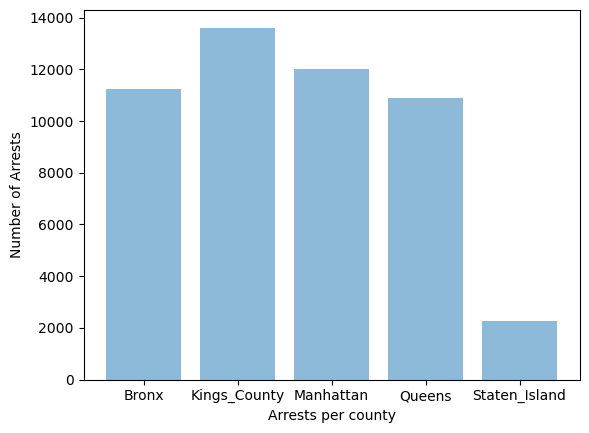

In [28]:
boroughs= ['Bronx','Kings_County', 'Manhattan', 'Queens', 'Staten_Island']
arrest=[11227, 13612, 12024, 10878, 2259]
x_axis = np.arange(len(arrest))
plt.bar(x_axis, arrest, align='center', alpha=0.5)
plt.xticks(x_axis, boroughs)
plt.ylabel('Number of Arrests')
plt.xlabel('Arrests per county')
plt.show()

In [136]:
# Get recods Jan-Apr for 2023
historical_df_sorted = historical_df_from_file.sort_values(by='Arrest date')
start_date = '2023-01-01'
end_date = '2023-03-31'
historical_df_filtered = historical_df_sorted.loc[(historical_df_sorted['Arrest date'] >= start_date) & (historical_df_sorted['Arrest date'] <= end_date)]
historical_df_filtered

Arrest date             Offense description Arrest boro  \
201372   2023-01-01T00:00:00.000         MISCELLANEOUS PENAL LAW           M   
201706   2023-01-01T00:00:00.000  OFFENSES AGAINST PUBLIC ADMINI           Q   
201701   2023-01-01T00:00:00.000    ASSAULT 3 & RELATED OFFENSES           K   
211515   2023-01-01T00:00:00.000                         ROBBERY           K   
201367   2023-01-01T00:00:00.000    ASSAULT 3 & RELATED OFFENSES           Q   
...                          ...                             ...         ...   
2328778  2023-03-30T00:00:00.000                        BURGLARY           M   
2328783  2023-03-30T00:00:00.000    NYS LAWS-UNCLASSIFIED FELONY           B   
223959   2023-03-30T00:00:00.000        OTHER TRAFFIC INFRACTION           Q   
2328753  2023-03-30T00:00:00.000               CRIMINAL TRESPASS           K   
2328777  2023-03-30T00:00:00.000                   PETIT LARCENY           K   

        Age group Sex            Race   Latitude  Longitude  \
201372      25-44   M           BLACK  40.722079 -73.988194   
201706      18-24   F  WHITE HISPANIC  40.691713 -73.864739   
201701      25-44   M  WHITE HISPANIC  40.646823 -73.999564   
211515        <18   M           BLACK  40.671404 -73.881509   
201367      25-44   M  WHITE HISPANIC  40.742866 -73.907244   
...           ...  ..             ...        ...        ...   
2328778     25-44   M           BLACK  40.805487 -73.946070   
2328783     45-64   M  WHITE HISPANIC  40.828660 -73.878235   
223959      25-44   U         UNKNOWN  40.749158 -73.869426   
2328753     25-44   M  WHITE HISPANIC  40.673924 -74.005219   
2328777     25-44   M           BLACK  40.681119 -73.974365   

                                                   lon_lat  
201372   {'type': 'Point', 'coordinates': [-73.988194, ...  
201706   {'type': 'Point', 'coordinates': [-73.86473874...  
201701   {'type': 'Point', 'coordinates': [-73.999564, ...  
211515   {'type': 'Point', 'coordinates': [-73.881509, ...  
201367   {'type': 'Point', 'coordinates': [-73.907244, ...  
...                                                    ...  
2328778  {'type': 'Point', 'coordinates': [-73.94607, 4...  
2328783  {'type': 'Point', 'coordinates': [-73.87823474...  
223959   {'type': 'Point', 'coordinates': [-73.86942584...  
2328753  {'type': 'Point', 'coordinates': [-74.005219, ...  
2328777  {'type': 'Point', 'coordinates': [-73.974365, ...  

[90428 rows x 9 columns]

In [137]:
historical_df_filtered.tail()

Arrest date           Offense description Arrest boro  \
2328778  2023-03-30T00:00:00.000                      BURGLARY           M   
2328783  2023-03-30T00:00:00.000  NYS LAWS-UNCLASSIFIED FELONY           B   
223959   2023-03-30T00:00:00.000      OTHER TRAFFIC INFRACTION           Q   
2328753  2023-03-30T00:00:00.000             CRIMINAL TRESPASS           K   
2328777  2023-03-30T00:00:00.000                 PETIT LARCENY           K   

        Age group Sex            Race   Latitude  Longitude  \
2328778     25-44   M           BLACK  40.805487 -73.946070   
2328783     45-64   M  WHITE HISPANIC  40.828660 -73.878235   
223959      25-44   U         UNKNOWN  40.749158 -73.869426   
2328753     25-44   M  WHITE HISPANIC  40.673924 -74.005219   
2328777     25-44   M           BLACK  40.681119 -73.974365   

                                                   lon_lat  
2328778  {'type': 'Point', 'coordinates': [-73.94607, 4...  
2328783  {'type': 'Point', 'coordinates': [-73.87823474...  
223959   {'type': 'Point', 'coordinates': [-73.86942584...  
2328753  {'type': 'Point', 'coordinates': [-74.005219, ...  
2328777  {'type': 'Point', 'coordinates': [-73.974365, ...

In [159]:

combined_df = pd.concat([historical_df, original_df])
combined_df

Arrest date                     Offense description  \
0      2014-01-01T00:00:00.000                                 ROBBERY   
1      2014-01-01T00:00:00.000                       CRIMINAL TRESPASS   
2      2014-01-01T00:00:00.000  OFFENSES AGAINST PUBLIC ADMINISTRATION   
3      2014-01-01T00:00:00.000                          FELONY ASSAULT   
4      2014-01-01T00:00:00.000            ASSAULT 3 & RELATED OFFENSES   
...                        ...                                     ...   
49995      2024-03-12 00:00:00          CRIMINAL MISCHIEF & RELATED OF   
49996      2024-03-20 00:00:00                          FELONY ASSAULT   
49997      2024-03-07 00:00:00            ASSAULT 3 & RELATED OFFENSES   
49998      2024-03-14 00:00:00            ASSAULT 3 & RELATED OFFENSES   
49999      2024-03-13 00:00:00                         DANGEROUS DRUGS   

      Arrest boro Age group Sex            Race            Latitude  \
0               B       <18   M           BLACK   40.83573258000007   
1               M     25-44   M           BLACK  40.814787465000045   
2               K     25-44   M           BLACK   40.57599199300005   
3               B     25-44   F           WHITE   40.81807858500007   
4               B     25-44   M  WHITE HISPANIC  40.837001024000074   
...           ...       ...  ..             ...                 ...   
49995           K       65+   F           BLACK           40.690859   
49996           M     25-44   M  BLACK HISPANIC           40.801908   
49997           M     25-44   M           BLACK           40.803121   
49998           B     25-44   F  WHITE HISPANIC           40.842311   
49999           Q     25-44   M  WHITE HISPANIC           40.687804   

                Longitude                                            lon_lat  \
0      -73.92128542599994  {'type': 'Point', 'coordinates': [-73.92128542...   
1      -73.95750196499995  {'type': 'Point', 'coordinates': [-73.95750196...   
2      -73.99060607299998  {'type': 'Point', 'coordinates': [-73.99060607...   
3      -73.89693760899996  {'type': 'Point', 'coordinates': [-73.89693760...   
4      -73.90370600899996  {'type': 'Point', 'coordinates': [-73.90370600...   
...                   ...                                                ...   
49995          -73.985848                                                NaN   
49996          -73.935612                                                NaN   
49997          -73.952599                                                NaN   
49998          -73.886588                                                NaN   
49999           -73.83356                                                NaN   

                                         geocoded_column  
0                                                    NaN  
1                                                    NaN  
2                                                    NaN  
3                                                    NaN  
4                                                    NaN  
...                                                  ...  
49995  {'type': 'Point', 'coordinates': [-73.985848, ...  
49996  {'type': 'Point', 'coordinates': [-73.935612, ...  
49997  {'type': 'Point', 'coordinates': [-73.952599, ...  
49998  {'type': 'Point', 'coordinates': [-73.886588, ...  
49999  {'type': 'Point', 'coordinates': [-73.83356012...  

[2552242 rows x 10 columns]

In [160]:
combined_df.tail()

Arrest date             Offense description Arrest boro  \
49995  2024-03-12 00:00:00  CRIMINAL MISCHIEF & RELATED OF           K   
49996  2024-03-20 00:00:00                  FELONY ASSAULT           M   
49997  2024-03-07 00:00:00    ASSAULT 3 & RELATED OFFENSES           M   
49998  2024-03-14 00:00:00    ASSAULT 3 & RELATED OFFENSES           B   
49999  2024-03-13 00:00:00                 DANGEROUS DRUGS           Q   

      Age group Sex            Race   Latitude  Longitude lon_lat  \
49995       65+   F           BLACK  40.690859 -73.985848     NaN   
49996     25-44   M  BLACK HISPANIC  40.801908 -73.935612     NaN   
49997     25-44   M           BLACK  40.803121 -73.952599     NaN   
49998     25-44   F  WHITE HISPANIC  40.842311 -73.886588     NaN   
49999     25-44   M  WHITE HISPANIC  40.687804  -73.83356     NaN   

                                         geocoded_column  
49995  {'type': 'Point', 'coordinates': [-73.985848, ...  
49996  {'type': 'Point', 'coordinates': [-73.935612, ...  
49997  {'type': 'Point', 'coordinates': [-73.952599, ...  
49998  {'type': 'Point', 'coordinates': [-73.886588, ...  
49999  {'type': 'Point', 'coordinates': [-73.83356012...

In [161]:
# Combined with only first 3 month of 2023
combined_df_filtered = pd.concat([historical_df_filtered, original_df])
combined_df_filtered

Arrest date             Offense description Arrest boro Age group Sex  \
201372  2023-01-01         MISCELLANEOUS PENAL LAW           M     25-44   M   
201706  2023-01-01  OFFENSES AGAINST PUBLIC ADMINI           Q     18-24   F   
201701  2023-01-01    ASSAULT 3 & RELATED OFFENSES           K     25-44   M   
211515  2023-01-01                         ROBBERY           K       <18   M   
201367  2023-01-01    ASSAULT 3 & RELATED OFFENSES           Q     25-44   M   
...            ...                             ...         ...       ...  ..   
49995   2024-03-12  CRIMINAL MISCHIEF & RELATED OF           K       65+   F   
49996   2024-03-20                  FELONY ASSAULT           M     25-44   M   
49997   2024-03-07    ASSAULT 3 & RELATED OFFENSES           M     25-44   M   
49998   2024-03-14    ASSAULT 3 & RELATED OFFENSES           B     25-44   F   
49999   2024-03-13                 DANGEROUS DRUGS           Q     25-44   M   

                  Race   Latitude  Longitude  \
201372           BLACK  40.722079 -73.988194   
201706  WHITE HISPANIC  40.691713 -73.864739   
201701  WHITE HISPANIC  40.646823 -73.999564   
211515           BLACK  40.671404 -73.881509   
201367  WHITE HISPANIC  40.742866 -73.907244   
...                ...        ...        ...   
49995            BLACK  40.690859 -73.985848   
49996   BLACK HISPANIC  40.801908 -73.935612   
49997            BLACK  40.803121 -73.952599   
49998   WHITE HISPANIC  40.842311 -73.886588   
49999   WHITE HISPANIC  40.687804 -73.833560   

                                                  lon_lat  \
201372  {'type': 'Point', 'coordinates': [-73.988194, ...   
201706  {'type': 'Point', 'coordinates': [-73.86473874...   
201701  {'type': 'Point', 'coordinates': [-73.999564, ...   
211515  {'type': 'Point', 'coordinates': [-73.881509, ...   
201367  {'type': 'Point', 'coordinates': [-73.907244, ...   
...                                                   ...   
49995                                                 NaN   
49996                                                 NaN   
49997                                                 NaN   
49998                                                 NaN   
49999                                                 NaN   

                                          geocoded_column  
201372                                                NaN  
201706                                                NaN  
201701                                                NaN  
211515                                                NaN  
201367                                                NaN  
...                                                   ...  
49995   {'type': 'Point', 'coordinates': [-73.985848, ...  
49996   {'type': 'Point', 'coordinates': [-73.935612, ...  
49997   {'type': 'Point', 'coordinates': [-73.952599, ...  
49998   {'type': 'Point', 'coordinates': [-73.886588, ...  
49999   {'type': 'Point', 'coordinates': [-73.83356012...  

[140428 rows x 10 columns]

In [162]:
combined_df_filtered.tail()

Arrest date             Offense description Arrest boro Age group Sex  \
49995  2024-03-12  CRIMINAL MISCHIEF & RELATED OF           K       65+   F   
49996  2024-03-20                  FELONY ASSAULT           M     25-44   M   
49997  2024-03-07    ASSAULT 3 & RELATED OFFENSES           M     25-44   M   
49998  2024-03-14    ASSAULT 3 & RELATED OFFENSES           B     25-44   F   
49999  2024-03-13                 DANGEROUS DRUGS           Q     25-44   M   

                 Race   Latitude  Longitude lon_lat  \
49995           BLACK  40.690859 -73.985848     NaN   
49996  BLACK HISPANIC  40.801908 -73.935612     NaN   
49997           BLACK  40.803121 -73.952599     NaN   
49998  WHITE HISPANIC  40.842311 -73.886588     NaN   
49999  WHITE HISPANIC  40.687804 -73.833560     NaN   

                                         geocoded_column  
49995  {'type': 'Point', 'coordinates': [-73.985848, ...  
49996  {'type': 'Point', 'coordinates': [-73.935612, ...  
49997  {'type': 'Point', 'coordinates': [-73.952599, ...  
49998  {'type': 'Point', 'coordinates': [-73.886588, ...  
49999  {'type': 'Point', 'coordinates': [-73.83356012...

In [187]:
race_counts_2024 = original_df['Race'].value_counts()
race_counts_2023 =historical_df_filtered['Race'].value_counts()
# Sort offenses by counts in descending order
race_counts_2023_sorted = race_counts_2023.sort_values(ascending=False)
race_counts_2024_sorted = race_counts_2024.sort_values(ascending=False)
race_counts_2024_adjusted = race_counts_2024_sorted.head(len(race_counts_2023_sorted))

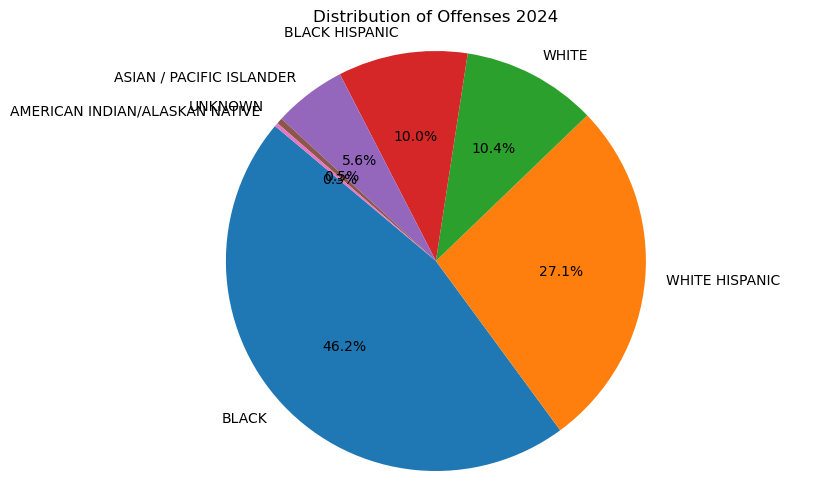

In [188]:
# Show plot fitrst 3 month of 2024 by race
showPieChart(race_counts_2024,"2024")

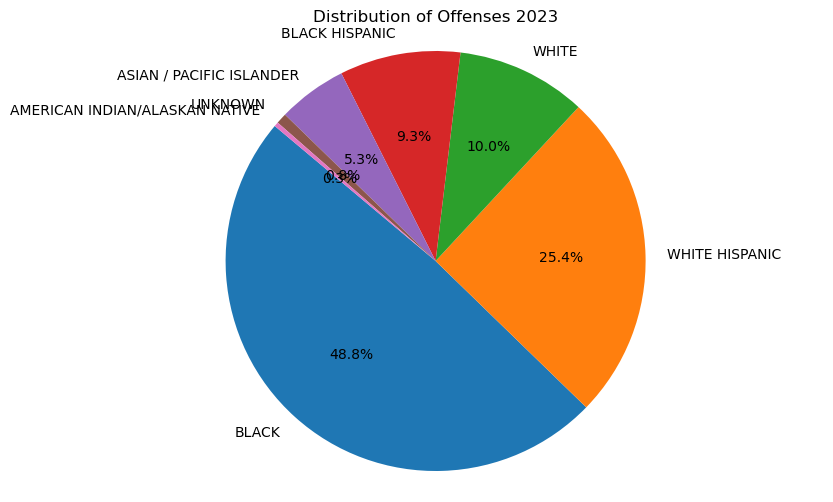

In [189]:
# Show plot fitrst 3 month of 2023 by race
showPieChart(race_counts_2023_sorted,"2023")

In [193]:
age_counts_2024 = original_df['Age group'].value_counts()
age_counts_2023 =historical_df_filtered['Age group'].value_counts()
# Sort offenses by counts in descending order
age_counts_2023_sorted = age_counts_2023.sort_values(ascending=False)
age_counts_2024_sorted = age_counts_2024.sort_values(ascending=False)
age_counts_2024_adjusted = age_counts_2024_sorted.head(len(age_counts_2023_sorted))

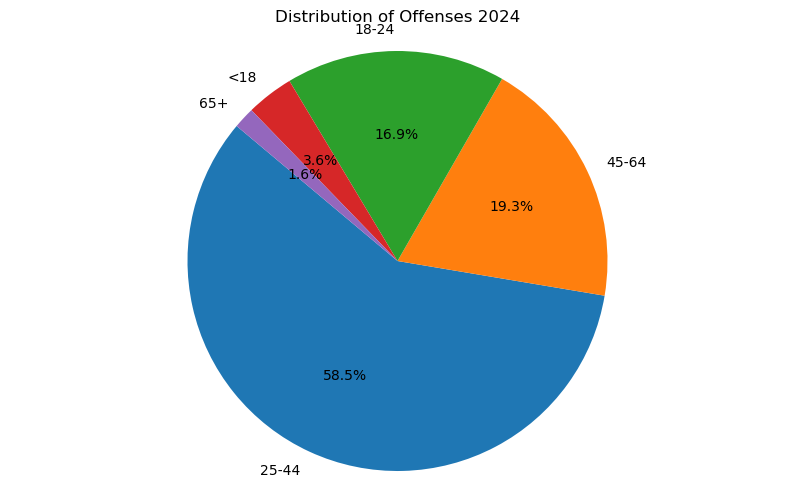

In [191]:
# Show plot fitrst 3 month of 2024 by age
showPieChart(age_counts_2024_sorted,"2024")

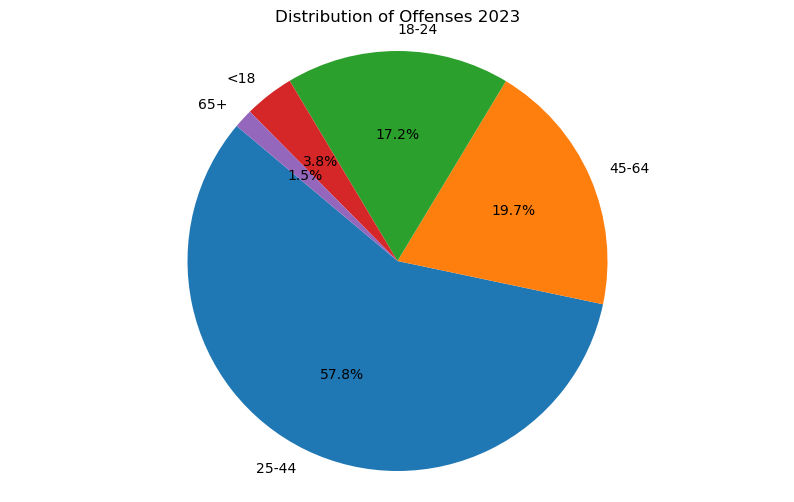

In [194]:
# Show plot fitrst 3 month of 2023 by age
showPieChart(age_counts_2023_sorted,"2023")

In [29]:
c = pd.read_csv("./final_census_df.csv")
c.head()

zip_code  population  poverty_rate  median_income
0       601       17242     62.475351          13092
1       602       38442     51.014515          16358
2       603       48814     49.856599          16603
3       606        6437     64.672984          12832
4       610       27073     43.305138          19309